In [60]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline

# Chapter 2: Kinematics

In [56]:
class TimeValue:
    def __init__(self, time, value):
        self.time = time * 1.0
        self.value = value * 1.0

    def __repr__(self):
        return '({}, {})'.format(self.time, self.value)

In [57]:
class TimeSeries:
    def __init__(self, points=[]):
        self.series = []
        for (time, value) in points:
            self.append(time, value)
        
    def append(self, time, value):
        self.series.append(TimeValue(time, value))
        self.series = sorted(self.series, key=lambda x: x.time)
        
    @property
    def initial(self):
        return self.series[0]
    
    @property
    def timeline(self):
        return [x.time for x in self.series]
    
    @property
    def values(self):
        return [x.value for x in self.series]
    
    @property
    def components(self, i=None):
        try:
            return list(zip(*self.values))
        except:
            return [self.values]

    def plot(self, toggle='0', title='', legend_loc='best', grid=True, marker=None, labels=None):
        if len(self.components) > 1:
            plt.plot(self.timeline, self.values, marker=marker)
            if legend_loc:
                plt.legend(['x','y','z'][:len(self.components)], loc=legend_loc, numpoints=1)
        else:
            r = self
            v = r.rate_of_change()
            a = v.rate_of_change()
            
            if '0' in toggle:
                plt.plot(r.timeline, r.values, marker=marker, label='position')
            if '1' in toggle:
                plt.plot(v.timeline, v.values, marker=marker, label='velocity')
            if '2' in toggle:
                plt.plot(a.timeline, a.values, marker=marker, label='acceleration')
            if legend_loc:
                if labels:
                    plt.legend(labels, loc=legend_loc, numpoints=1)
                else:
                    plt.legend(loc=legend_loc, numpoints=1)
        plt.title(title)
        plt.xlabel('Time')
        plt.margins(0.05)
        dt = 0.03 * (self.timeline[-1] - self.timeline[0])
        plt.axes().set_xlim([self.timeline[0] - dt, self.timeline[-1] + dt])
        if grid:
            plt.axes().axhline(0, c='k')
            plt.grid(True)

        
    def plot2d(self, x_index=0, y_index=1, toggle='0', title='', color='', labels=[],
               grid=True, legend_loc='lower left', markevery=0, arrows=False):
        
        r = self
        rx = r.components[x_index]
        ry = r.components[y_index]

        v = r.rate_of_change()
        vx = v.components[x_index]
        vy = v.components[y_index]

        a = v.rate_of_change()
        ax = a.components[x_index]
        ay = a.components[y_index]

        if color:
            r_color, v_color, a_color = color * 3
        else:
            r_color, v_color, a_color = 'bgr'
        
        if labels:
            r_label, v_label, a_label = labels
        else:
            r_label, v_label, a_label = ['position','velocity','acceleration']
        
        if '0' in toggle:
            plt.plot(rx, ry, c=r_color, label=r_label,
                     markevery=[-1], marker='o', mfc='w', mec=r_color, mew=1)
            if markevery:
                plt.plot(rx, ry, lw=0, markevery=markevery, marker='.', mec=r_color)

        if '1' in toggle:
            plt.plot(vx, vy, c=v_color, label=v_label,
                     markevery=[-1], marker='o', mfc='w', mec=v_color, mew=1)            
            if markevery:
                plt.plot(vx, vy, lw=0, markevery=markevery, marker='.', mec=v_color)

        if '2' in toggle:
            plt.plot(ax, ay, c=a_color, label=a_label, 
                     markevery=[-1], marker='o', mfc='w', mec=a_color, mew=1)
            if markevery:
                plt.plot(ax, ay, lw=0, markevery=markevery, marker='.', mec=a_color)
            
        plt.axes().set_aspect('equal')
        plt.margins(0.05)
        if legend_loc and len(toggle) > 1:
            plt.legend(numpoints=1, loc=legend_loc)
        plt.title(title)
        
        if grid:
            plt.axes().axhline(0, c='k')
            plt.axes().axvline(0, c='k')
            plt.grid(True)

        if arrows:
            xmin, xmax = plt.xlim()
            ymin, ymax = plt.ylim()
            size = 0.5 * (xmax - xmin) + 0.5 * (ymax - ymin)
            head_size = {
                'head_width': 0.03 * size,
                'head_length': 0.05 * size,
            }
            if '1' in toggle:
                plt.axes().arrow(rx[-1], ry[-1], vx[-1], vy[-1], 
                                 fc=v_color, ec=v_color, **head_size)
            if '2' in toggle:
                plt.axes().arrow(rx[-1], ry[-1], ax[-1], ay[-1], 
                                 fc=a_color, ec=a_color, **head_size)
             
    @property
    def intervals(self):
        intervals = []
        for i in range(1, len(self.series)):
            intervals.append((self.series[i - 1], self.series[i]))
        return intervals    
 
    def get_interval(self, time): # closed on left [a, b)
        tmin = min(self.timeline)
        tmax = max(self.timeline)
        if time < tmin:
            return None, self.series[0]
        elif time >= tmax:
            return self.series[-1], None
        else:
            for a, b in self.intervals:
                if a.time <= time and time < b.time:
                    return a, b
    
    def rate_of_change(self):
        ts = TimeSeries()
        for i, (a, b) in enumerate(self.intervals):
            dx = b.value - a.value
            dt = b.time - a.time
            if 1 == 0:
                ts.append(a.time, dx/dt)
            else:
                ts.append(a.time + dt/2, dx/dt)
        return ts
                
    def __call__(self, time):
        a, b = self.get_interval(time)
        # this method will not extrapolate, but we do need to take care of this edge case...
        if b is None and round(a.time - time, 10) == 0:
            return a.value
        else:
            dx = b.value - a.value
            dt = b.time - a.time
            return a.value + dx/dt * (time - a.time)
        
    def __repr__(self):
        import pprint
        return pprint.pformat(self.series)


**Free fall motion (no air drag)**

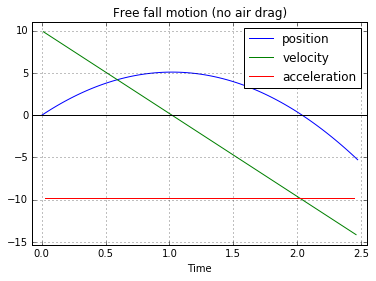

In [4]:
y = TimeSeries()
for i in range(100):
    t = i/40
    y.append(t, 10*t-4.9*t**2)
y.plot(title='Free fall motion (no air drag)',toggle='012')

**Uniform circular motion**

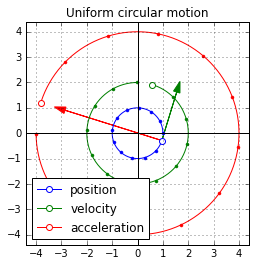

In [5]:
r = TimeSeries()
for q in range(600):
    t = q / 100
    x = 1.0 * np.cos(t)
    y = 1.0 * np.sin(t)
    r.append(0.5 * t, np.array([x,y]))
r.plot2d(title='Uniform circular motion', toggle='012', markevery=50, arrows=True)

**The components of UCM are SHM**

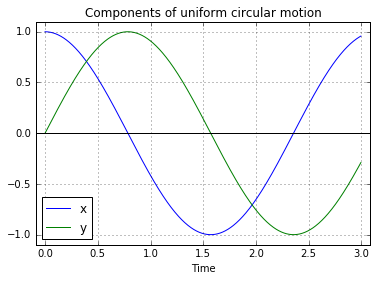

In [6]:
r.plot(title='Components of uniform circular motion')

# Chapter 4: Dynamics

In [58]:
class Particle():
    def __init__(self, mass=1, t0=0, r0=0, p0=0, v0=None):
        self.mass = mass
        self.position = TimeSeries([(t0, r0)])
        if self.mass and v0 is not None:
            self.momentum = TimeSeries([(t0, self.mass * v0)])
        else:
            self.momentum = TimeSeries([(t0, p0)])
        self.forces = []

    def addforce(self, force):
        self.forces.append(lambda t, obj=self: force(obj, t))        
        
    def netforce(self, time): # momentum flow or rate of change
        netforce = 0
        for f in self.forces:
            netforce += f(time)
        return netforce

    def velocity(self, time): # position flow or rate of change
        if time > max(self.momentum.timeline):
            time = max(self.momentum.timeline)
        return self.momentum(time) / self.mass

    def increment(self, dt, n=1):
        for i in range(n):
            t = max(self.position.timeline)

            if len(self.position.timeline) == 1: # then only go forward half an increment            
                next_p = self.momentum(t) + self.netforce(t) * dt/2
                self.momentum = TimeSeries() # throw out that "initial" value
            else: # reach back half an increment to calculate the new momentum value
                next_p = self.momentum(t - dt/2) + self.netforce(t) * dt

            self.momentum.append(t + dt/2, next_p)
            next_r = self.position(t) + self.velocity(t + dt/2) * dt        
            self.position.append(t + dt, next_r)

**Confirm calculation with constant acceleration**

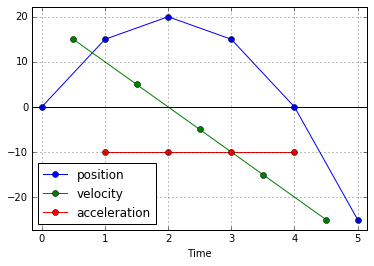

In [8]:
obj = Particle(v0=20)
obj.netforce = lambda t: -10
obj.increment(1, 5)
obj.position.plot(toggle='012', marker='o')

**Free fall with air drag**

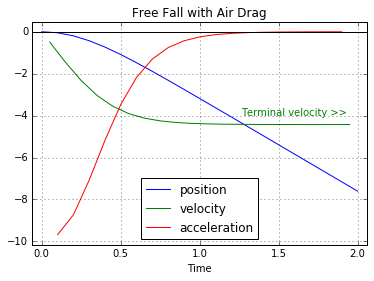

Terminal velocity = -4.43 m/s


In [9]:
def weight(obj, t):
    return -9.8 * obj.mass

def air_drag(obj, t):
    return 0.5 * obj.velocity(t) ** 2

obj = Particle(v0=0)
obj.addforce(weight)
obj.addforce(air_drag)
obj.increment(0.1, 20)
obj.position.plot('012', title='Free Fall with Air Drag')
plt.annotate('Terminal velocity >>', color='green', xy=(1.6,-4.0), ha='center')
plt.show()
print('Terminal velocity = {:.02f} m/s'.format(obj.velocity(2)))

**Damped harmonic motion**

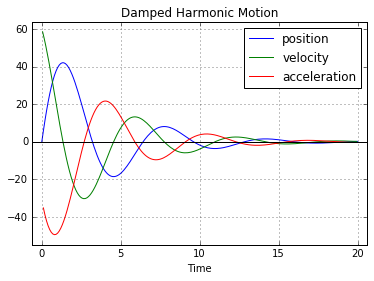

In [10]:
def spring_force(obj, t):
    return -obj.position(t)

def damping_force(obj, t):
    return -0.5 * obj.velocity(t)

obj = Particle(v0=60)
obj.addforce(spring_force)
obj.addforce(damping_force)
obj.increment(0.1, 200)
obj.position.plot('012', title='Damped Harmonic Motion')

**Driven harmonic motion (general case)**

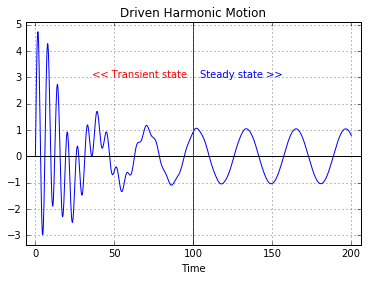

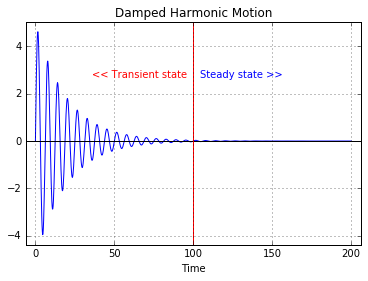

In [59]:
def spring_force(obj, t):
    return -obj.position(t)

def damping_force(obj, t):
    return -0.1 * obj.velocity(t)

def driving_force(obj, t):
    return np.sin(0.2*t)

obj = Particle(v0=5)
obj.addforce(spring_force)
obj.addforce(damping_force)
obj.addforce(driving_force)
obj.increment(0.2, 1000)

obj.position.plot(title='Driven Harmonic Motion', legend_loc=None)
plt.axvline(100, c='r')
plt.annotate('<< Transient state', xy=(0.48,0.75), xycoords='axes fraction', ha='right', color='r')
plt.annotate('Steady state >>', xy=(0.52,0.75), xycoords='axes fraction', ha='left', color='b')

plt.show()

obj = Particle(v0=5)
obj.addforce(spring_force)
obj.addforce(damping_force)
# obj.addforce(driving_force)
obj.increment(0.2, 1000)

obj.position.plot(title='Damped Harmonic Motion', legend_loc=None)
plt.axvline(100, c='r')
plt.annotate('<< Transient state', xy=(0.48,0.75), xycoords='axes fraction', ha='right', color='r')
plt.annotate('Steady state >>', xy=(0.52,0.75), xycoords='axes fraction', ha='left', color='b')

plt.show()

**Driven harmonic motion (near resonance)**

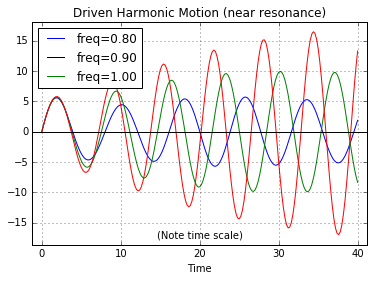

In [12]:
def spring_force(obj, t):
    return -obj.position(t)

def damping_force(obj, t):
    return -0.1 * obj.velocity(t)

def driving_force(obj, t, freq):
    return 2 * np.sin(freq * t)

for freq in [0.8, 0.9, 1.0]:
    obj = Particle(v0=5)
    obj.addforce(spring_force)
    obj.addforce(damping_force)
    obj.addforce(lambda obj, t, freq=freq: driving_force(obj, t, freq))
    obj.increment(0.2, 200)
    obj.position.plot()

plt.title('Driven Harmonic Motion (near resonance)')
plt.legend(['freq=0.80','freq=0.90','freq=1.00'], loc='upper left')
plt.annotate('(Note time scale)', xy=(0.50,0.02), xycoords='axes fraction', ha='center', va='bottom')
plt.show()

**Resonance curve**

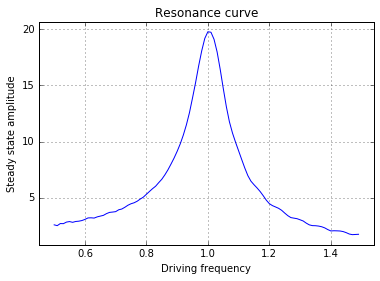

In [13]:
# Note: this may take some time to process...

def spring_force(obj, t):
    return -obj.position(t)

def damping_force(obj, t):
    return -0.1 * obj.velocity(t)

def driving_force(obj, t, freq):
    return 2 * np.sin(freq * t)

data = []
n = 100
for i in range(n):
    freq = 0.50 + i / n
    obj = Particle(v0=10)  
    obj.addforce(spring_force)
    obj.addforce(damping_force)
    obj.addforce(lambda obj, t, freq=freq: driving_force(obj, t, freq))
    obj.increment(0.2, 500)
    ampl = max(obj.position.values[-50:])
    data.append((freq, ampl))
plt.plot(*zip(*data))
plt.margins(0.05)
plt.title('Resonance curve')
plt.xlabel('Driving frequency')
plt.ylabel('Steady state amplitude')
plt.grid(True)
plt.show()

**2D projectile motion with air drag**

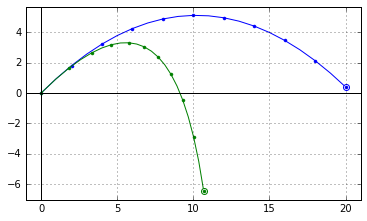

In [14]:
def weight(obj, t):
    return obj.mass * np.array([0, -9.8])

def air_drag(obj, t):
    return -0.1 * obj.velocity(t) ** 2

obj = Particle(t0=0, r0=np.array([0,0]), v0=np.array([10,10]))
obj.addforce(weight)
obj.increment(0.1, 20)
obj.position.plot2d(markevery=2)

obj = Particle(t0=0, r0=np.array([0,0]), v0=np.array([10,10]))
obj.addforce(weight)
obj.addforce(air_drag)
obj.increment(0.1, 20)
obj.position.plot2d(markevery=2, color='g')

**Uniform circular motion**

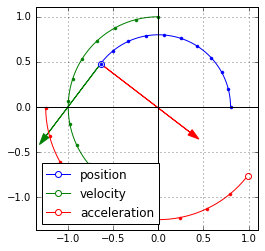

In [15]:
obj = Particle(t0=0, r0=np.array([0.8,0]), v0=np.array([0,1]))

def centripetal(obj, t):
    rx, ry = obj.position(t)
    vx, vy = obj.velocity(t)
    rmag2 = rx ** 2 + ry ** 2
    vmag2 = vx ** 2 + vy ** 2
    return -obj.mass * np.array([rx, ry]) * vmag2 / rmag2
        
obj.addforce(centripetal)
obj.increment(dt=0.01, n=200)
obj.position.plot2d(toggle='012', markevery=20, arrows=True)

**Newton's law of gravity**

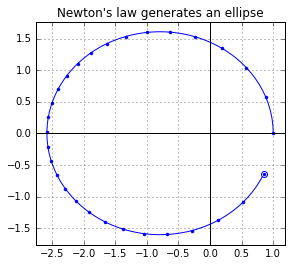

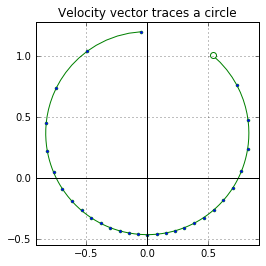

In [16]:
def gravitation_fixed(obj, t):
    x, y = obj.position(t)
    d = np.sqrt( x ** 2 + y ** 2 )
    return -obj.mass * np.array([x,y]) / d ** 3

obj = Particle(t0=0, r0=np.array([1,0]), v0=np.array([0,1.2]))
obj.addforce(gravitation_fixed)
obj.increment(dt=0.1, n=145)

plt.figure()
obj.position.plot2d(toggle='0', markevery=5)
plt.title("Newton's law generates an ellipse")
plt.figure()
obj.position.plot2d(toggle='1', markevery=5)
plt.title('Velocity vector traces a circle')
plt.show()

**Newton's law of gravity in 3D**

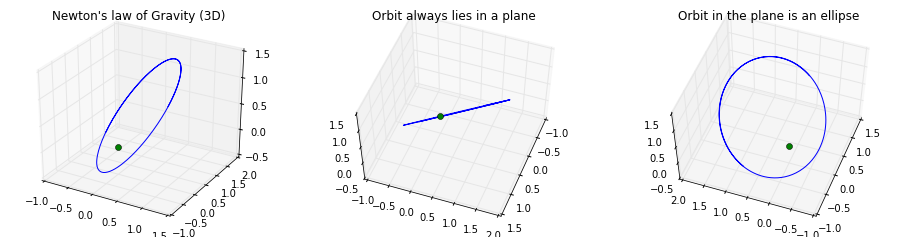

In [17]:
def gravitation_fixed_3d(obj, t):
    x, y, z = obj.position(t)
    d = np.sqrt( x ** 2 + y ** 2 + z ** 2 )
    return -obj.mass * np.array([x,y,z]) / d ** 3

obj = Particle(t0=0, r0=np.array([1,0,1]), v0=np.array([0.1,0.6,0.5]))
obj.addforce(gravitation_fixed_3d)
obj.increment(dt=0.05, n=300)

rx, ry, rz = obj.position.components

fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot(rx, ry, rz)
ax.plot([0],[0],[0], marker='o')
plt.title("Newton's law of Gravity (3D)")

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot(rx, ry, rz)
ax.view_init(elev=57, azim=20)
ax.plot([0],[0],[0], marker='o')
plt.title("Orbit always lies in a plane")

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot(rx, ry, rz)
ax.view_init(elev=57, azim=200)
ax.plot([0],[0],[0], marker='o')
plt.title("Orbit in the plane is an ellipse")

plt.show()

**Rutherford scattering**

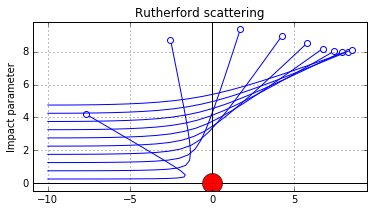

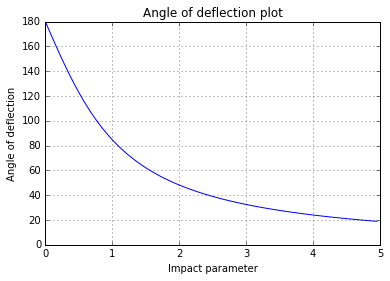

In [18]:
def coulomb_fixed(obj, t):
    x, y = obj.position(t)
    d = np.sqrt( x ** 2 + y ** 2 )
    return np.array([x,y]) / d ** 3

objs = []
for i in range(100):
    b = i/20
    objs.append(Particle(t0=0, r0=np.array([-10,b]), v0=np.array([1,0])))
    objs[i].addforce(coulomb_fixed)
    objs[i].increment(dt=1, n=20)
    if i % 10 == 5:
        objs[i].position.plot2d()
plt.title('Rutherford scattering')
plt.ylabel('Impact parameter')
plt.plot(0,0, marker='o', ms=20, mfc='r')
plt.show()

x = [obj.position.values[0][1] for obj in objs]
v = []
for obj in objs: # calculated above
    v.append(obj.velocity(obj.position.timeline[-1]))
y = [np.arctan2(a[1], a[0]) * 180 / np.pi for a in v]
plt.plot(x, y)
plt.title('Angle of deflection plot')
plt.xlabel('Impact parameter')
plt.ylabel('Angle of deflection')
plt.grid(True)
plt.show()

# Chapter 7: Interaction and Collisions

In [19]:
class PhysicalSystem():
    def __init__(self, initial=[]):
        self.objs = list()
        for (mass, r0, v0) in initial:
            self.objs.append(Particle(mass=mass, r0=r0, v0=v0))
                    
        for obj1 in self.objs:
            for obj2 in self.objs:
                if obj1 != obj2: # no self-interactions !
                    internal_force = lambda t, obj1=obj1, obj2=obj2: self.interaction(obj1, obj2, t)
                    obj1.forces.append(internal_force)
                    
    def interaction(self, obj1, obj2, time):
        return 0
                    
    def increment(self, dt, n=1):
        for i in range(n):
            for obj in self.objs:
                obj.increment(dt)
                
    def plot(self):
        for i, obj in enumerate(self.objs):
            obj.position.plot(legend_loc=None)
            
    def plot2d(self, colors='bgrcmyk'*9, **kwargs):
        for i, obj in enumerate(self.objs):
            obj.position.plot2d(color=colors[i], **kwargs)

**Coulomb scattering (elastic)**

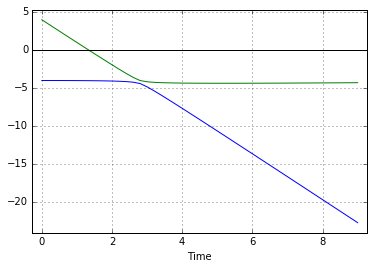

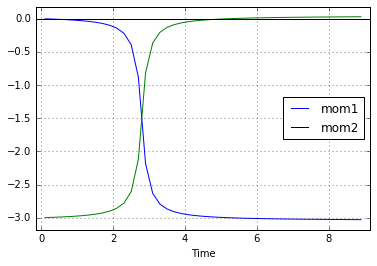

In [20]:
## SOMETHING IS NOT RIGHT HERE...
## TRY THIS WITH NON-SYMMETRIC MASSES...

def coulomb_1d(obj1, obj2, time):
    x1 = obj1.position(time)
    x2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 )
    return (x1 - x2) / d ** 3

ps = PhysicalSystem([(1,-4,0),(1,4,-3)])
ps.interaction = coulomb_1d
ps.increment(0.2, 45)
ps.plot()
plt.show()

ps.objs[0].momentum.plot()
ps.objs[1].momentum.plot()
plt.legend(['mom1','mom2'], loc='center right')
plt.show()

**Elastic bounce** (unfortunately requires a hack)

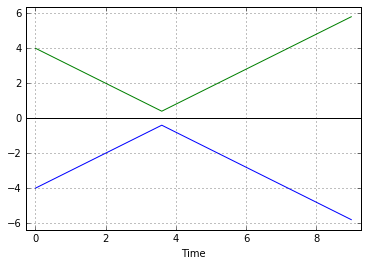

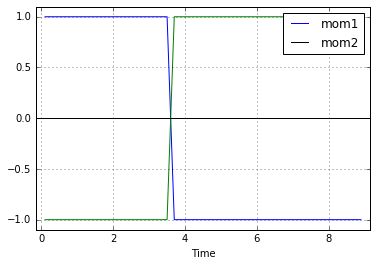

In [21]:
## SOMETHING IS NOT RIGHT HERE...
## TRY THIS WITH NON-SYMMETRIC VELOCITIES...

dt = 0.2 # This is a global variable used in the interaction

def contact_1d(obj1, obj2, time):
    elastisity = 1 
    if time > min(obj1.position.timeline):
        x1 = obj1.position(time)
        x2 = obj2.position(time)
        d = np.sqrt( (x1 - x2) ** 2 )
        x1_prev = obj1.position(time - dt)
        x2_prev = obj2.position(time - dt)VELOCITIES...

dt = 0.2 # This is a global variable used in the interaction

def contact_1d(obj1, obj2, time):
    elastisity = 1 
        d_prev = np.sqrt( (x1_prev - x2_prev) ** 2 )
        if d <= 1 and d_prev > 1:
            dp = -(elastisity + 1) * obj1.momentum(time - dt/2)
            return dp / dt
        else:
            return 0
    else:
        return 0

ps = PhysicalSystem([(1,-4,1),(1,4,-1)])
ps.interaction = contact_1d
ps.increment(dt, 45)
ps.plot()
plt.show()

ps.objs[0].momentum.plot()
ps.objs[1].momentum.plot()
plt.legend(['mom1','mom2'])
plt.show()

**Coulomb scattering 2D**

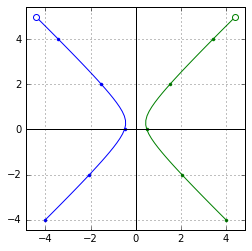

In [22]:
def coulomb(obj1, obj2, time):
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return np.array([(x1 - x2),(y1 - y2)]) / d ** 3

m1 = 1
r01 = np.array([-4,-4])
v01 = np.array([1,1])

m2 = 1
r02 = np.array([4,-4])
v02 = np.array([-1,1])

ps = PhysicalSystem([(m1,r01,v01),(m2,r02,v02)])
ps.interaction = coulomb
ps.increment(0.2, 45)
ps.plot2d(markevery=10)

**Ball in a box**

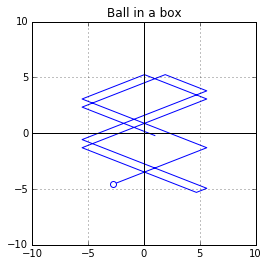

In [23]:
def box(obj, time, dt): 
    dpx, dpy = 0, 0
    if time > min(obj.position.timeline): # must let the clock tick once
        x, y = obj.position(time)
        x_prev, y_prev = obj.position(time - dt)
        px, py = obj.momentum(time - dt/2)
        if abs(x) >= 5 and abs(x_prev) < 5:
            dpx = -2 * px
        if abs(y) >= 5 and abs(y_prev) < 5:
            dpy = -2 * py
    return np.array([dpx, dpy]) / dt

import random
random.seed(1234)

q = 2 * np.pi * random.random()
r0 = np.array([np.cos(q), np.sin(q)])
d = 2 * np.pi * random.random()
v0 = np.array([np.cos(d), np.sin(d)])

ps = PhysicalSystem([(1, r0, v0)])
ps.interaction = coulomb
dt = 1
for obj in ps.objs:
    obj.forces.append(lambda time, obj=obj, dt=dt: box(obj, time, dt))
ps.increment(dt, 100)

ps.plot2d()
plt.title('Ball in a box')

z = 10
plt.axis([-z,z,-z,z])
plt.show()

**Gravitational slingshot**

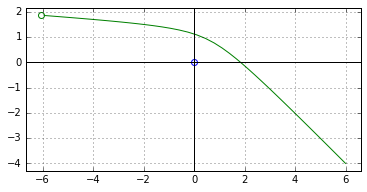

In [24]:
def gravitation(obj1, obj2, time):
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return -obj1.mass * obj2.mass * np.array([(x1 - x2),(y1 - y2)]) / d ** 3

m1 = 1
r01 = np.array([0,0])
v01 = np.array([0,0])

m2 = 0.001
r02 = np.array([6,-4])
v02 = np.array([-1,1])

ps = PhysicalSystem([(m1,r01,v01),(m2,r02,v02)])
ps.interaction = gravitation
ps.increment(0.2, 45)
ps.plot2d()

**Gravitational orbit (large central mass)**

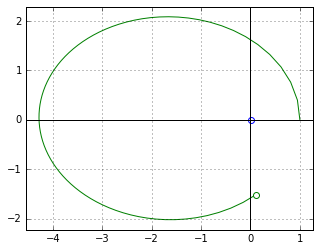

In [25]:
obj = Particle(t0=0, r0=np.array([1,0]), v0=np.array([0,1.2]))

def gravitation(obj1, obj2, time):
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return -obj1.mass * obj2.mass * np.array([(x1 - x2),(y1 - y2)]) / d ** 3

m1 = 1000
r01 = np.array([0,0])
v01 = np.array([0,-0.040]) # required to keep total momentum zero

m2 = 1
r02 = np.array([1,0])
v02 = np.array([0,40])

ps = PhysicalSystem([(m1,r01,v01),(m2,r02,v02)])
ps.interaction = gravitation
ps.increment(0.01, 80)
ps.plot2d()

**Gravitational co-orbit (similar central mass)**

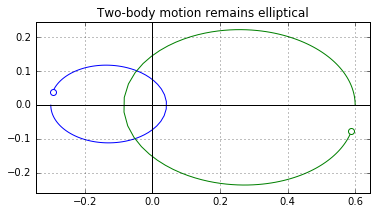

In [26]:
obj = Particle(t0=0, r0=np.array([1,0]), v0=np.array([0,1.2]))

def gravitation(obj1, obj2, time):
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return -obj1.mass * obj2.mass * np.array([(x1 - x2),(y1 - y2)]) / d ** 3

m1 = 2
r01 = np.array([-0.3,0])
v01 = np.array([0,-0.3])

m2 = 1
r02 = np.array([0.6,0])
v02 = np.array([0,0.6])

ps = PhysicalSystem([(m1,r01,v01),(m2,r02,v02)])
ps.interaction = gravitation
ps.increment(0.01, 125)
ps.plot2d()
plt.title('Two-body motion remains elliptical')
plt.show()

**Three body problem (equilateral)**

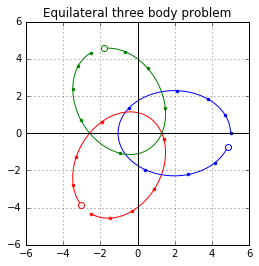

In [27]:
obj = Particle(t0=0, r0=np.array([1,0]), v0=np.array([0,1.2]))

def gravitation(obj1, obj2, time):
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return -obj1.mass * obj2.mass * np.array([(x1 - x2),(y1 - y2)]) / d ** 3

r0 = 5
v0 = 0.2

m1 = 1
r01 = np.array([r0*np.cos(0*np.pi/6),r0*np.sin(0*np.pi/6)])
v01 = np.array([v0*np.cos(3*np.pi/6),v0*np.sin(3*np.pi/6)])

m2 = 1
r02 = np.array([r0*np.cos(4*np.pi/6),r0*np.sin(4*np.pi/6)])
v02 = np.array([v0*np.cos(7*np.pi/6),v0*np.sin(7*np.pi/6)])

m3 = 1
r03 = np.array([r0*np.cos(8*np.pi/6),r0*np.sin(8*np.pi/6)])
v03 = np.array([v0*np.cos(11*np.pi/6),v0*np.sin(11*np.pi/6)])

initial = []
initial.append((m1,r01,v01))
initial.append((m2,r02,v02))
initial.append((m3,r03,v03))

ps = PhysicalSystem(initial)
ps.interaction = gravitation
ps.increment(0.1, 399)
ps.plot2d(markevery=50)
plt.title('Equilateral three body problem')

z = 6
plt.axis([-z,z,-z,z])
plt.show()

**Three body problem (star-planet-moon)**

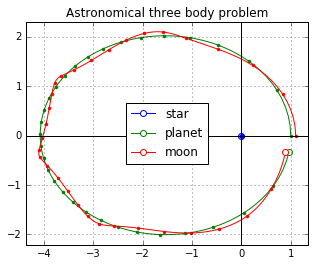

In [28]:
obj = Particle(t0=0, r0=np.array([1,0]), v0=np.array([0,1.2]))

def gravitation(obj1, obj2, time):
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return -obj1.mass * obj2.mass * np.array([(x1 - x2),(y1 - y2)]) / d ** 3

m1 = 1000
r01 = np.array([0,0])
v01 = np.array([0,-0.040]) # required to keep total momentum zero

m2 = 1
r02 = np.array([1,0])
v02 = np.array([0,40])

m3 = 0.001
r03 = np.array([1.1, 0])
v03 = np.array([0,36])

initial = []
initial.append((m1,r01,v01))
initial.append((m2,r02,v02))
initial.append((m3,r03,v03))

ps = PhysicalSystem(initial)
ps.interaction = gravitation
ps.increment(0.005, 159)
ps.plot2d(markevery=5, labels=['','',''])
plt.title('Astronomical three body problem')

plt.plot([], label="star", color='b', marker='o', mfc='w', mec='b', mew=1)  
plt.plot([], label="planet", color='g', marker='o', mfc='w', mec='g', mew=1)
plt.plot([], label="moon", color='r', marker='o', mfc='w', mec='r', mew=1)

plt.legend(loc='center', numpoints=1)
plt.show()

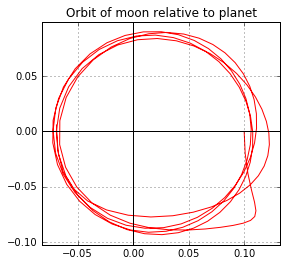

In [29]:
o0 = ps.objs[0].position.values
o1 = ps.objs[1].position.values
o2 = ps.objs[2].position.values

x = [ps.objs[2].position(t) - ps.objs[1].position(t) for t in ps.objs[0].position.timeline]
plt.plot(*zip(*x), c='r')
plt.axes().set_aspect('equal')

plt.margins(0.05)
plt.title('Orbit of moon relative to planet')

plt.axes().axhline(0, c='k')
plt.axes().axvline(0, c='k')
plt.grid(True)

**Six body problem !**

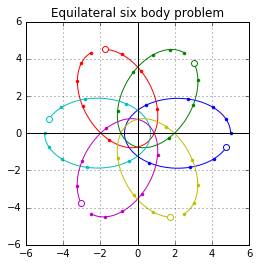

In [30]:
obj = Particle(t0=0, r0=np.array([1,0]), v0=np.array([0,1.2]))

def gravitation(obj1, obj2, time):
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return -obj1.mass * obj2.mass * np.array([(x1 - x2),(y1 - y2)]) / d ** 3

r0 = 5
v0 = 0.3

m1 = 1
r01 = np.array([r0*np.cos(0*np.pi/6),r0*np.sin(0*np.pi/6)])
v01 = np.array([v0*np.cos(3*np.pi/6),v0*np.sin(3*np.pi/6)])

m2 = 1
r02 = np.array([r0*np.cos(2*np.pi/6),r0*np.sin(2*np.pi/6)])
v02 = np.array([v0*np.cos(5*np.pi/6),v0*np.sin(5*np.pi/6)])

m3 = 1
r03 = np.array([r0*np.cos(4*np.pi/6),r0*np.sin(4*np.pi/6)])
v03 = np.array([v0*np.cos(7*np.pi/6),v0*np.sin(7*np.pi/6)])

m4 = 1
r04 = np.array([r0*np.cos(6*np.pi/6),r0*np.sin(6*np.pi/6)])
v04 = np.array([v0*np.cos(9*np.pi/6),v0*np.sin(9*np.pi/6)])

m5 = 1
r05 = np.array([r0*np.cos(8*np.pi/6),r0*np.sin(8*np.pi/6)])
v05 = np.array([v0*np.cos(11*np.pi/6),v0*np.sin(11*np.pi/6)])

m6 = 1
r06 = np.array([r0*np.cos(10*np.pi/6),r0*np.sin(10*np.pi/6)])
v06 = np.array([v0*np.cos(13*np.pi/6),v0*np.sin(13*np.pi/6)])

initial = []
initial.append((m1,r01,v01))
initial.append((m2,r02,v02))
initial.append((m3,r03,v03))
initial.append((m4,r04,v04))
initial.append((m5,r05,v05))
initial.append((m6,r06,v06))

ps = PhysicalSystem(initial)
ps.interaction = gravitation
ps.increment(0.05, 399)
ps.plot2d(markevery=50)
plt.title('Equilateral six body problem')

z = 6
plt.axis([-z,z,-z,z])
plt.show()

**Solar system**

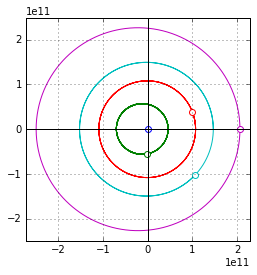

In [31]:
def gravitation(obj1, obj2, time):
    G = 6.674E-11
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return -G * obj1.mass * obj2.mass * np.array([(x1 - x2),(y1 - y2)]) / d ** 3

initial = []

m = 1.989E30
r0 = np.array([0,0])
v0 = np.array([0,0])
initial.append((m,r0,v0))

planets = []

planets.append('Mercury') # T = 88, a = 5.791E10, e = 0.2056, v = 47.36, q0 = 29°
m = 3.3301E23
r0 = np.array([4.600E10,0])
v0 = np.array([0,5.8937E4])
initial.append((m,r0,v0))

planets.append('Venus') # T = 225, a = 1.082E11, e = 0.0067, v = 35.02, q0 = 55°
m = 4.868E24
r0 = np.array([1.075E11,0])
v0 = np.array([0,3.5255E4])
initial.append((m,r0,v0))

planets.append('Earth') # T = 365, a = 1.496E11, e = 0.0167, v = 29.78, q0 = 114°
m = 5.972E24
r0 = np.array([1.471E11,0])
v0 = np.array([0,3.0289E4])
initial.append((m,r0,v0))

planets.append('Mars') # T = 687, a = 2.279E11, e = 0.0934, v = 24.08, q0 = 287°
m = 6.390E23
r0 = np.array([2.067E11,0])
v0 = np.array([0,2.6496E4])
initial.append((m,r0,v0))

# planets.append('Jupiter') # T = 4333, a = 7.783E11, e = 0.0485, v = 13.07, q0 = 274°
# m = 1.898E27
# r0 = np.array([7.406E11,0])
# v0 = np.array([0,1.3720E4])
# initial.append((m,r0,v0))

# planets.append('Saturn') # T = 10759, a = 1.429E12, e = 0.0555, v = 9.69, q0 = 339°
# m = 5.684E26
# r0 = np.array([1.350E12,0])
# v0 = np.array([0,1.0190E4])
# initial.append((m,r0,v0))

# planets.append('Uranus') # T = 30689, a = 2.875E12, e = 0.0463, v = 6.80, q0 = 97°
# m = 8.681E25
# r0 = np.array([2.742E12,0])
# v0 = np.array([0,0.7117E4])
# initial.append((m,r0,v0))

# planets.append('Neptune') # T = 60182, a = 4.504E12, e = 0.0095, v = 5.43, q0 = 276°
# m = 1.024E26
# r0 = np.array([4.460E12,0])
# v0 = np.array([0,0.5482E4])
# initial.append((m,r0,v0))

ps = PhysicalSystem(initial)
ps.interaction = gravitation
ps.increment(86400, 687)
# ps.increment(86400*10, 600)
# ps.increment(86400*100, 602)
ps.plot2d()

In [32]:
for i, obj in enumerate(ps.objs[1:]):
    a0 = min(np.sqrt(x**2 + y**2) for x, y in obj.position.values)
    a1 = max(np.sqrt(x**2 + y**2) for x, y in obj.position.values)
    a = (a1 + a0) / 2
    e = (a1 - a0) / (a1 + a0)
    print('{: <8}: a = {:0.3e}, e = {:.4f}'.format(planets[i], a, e))

Mercury : a = 5.791e+10, e = 0.2056
Venus   : a = 1.082e+11, e = 0.0067
Earth   : a = 1.496e+11, e = 0.0167
Mars    : a = 2.279e+11, e = 0.0932


In [33]:
# Mercury: T =    88, a = 5.791E10, e = 0.2056, v = 47.36, q0 =  29°
# Venus:   T =   225, a = 1.082E11, e = 0.0067, v = 35.02, q0 =  55°
# Earth':  T =   365, a = 1.496E11, e = 0.0167, v = 29.78, q0 = 114°
# Mars':   T =   687, a = 2.279E11, e = 0.0934, v = 24.08, q0 = 287°
# Jupiter: T =  4333, a = 7.783E11, e = 0.0485, v = 13.07, q0 = 274°
# Saturn:  T = 10759, a = 1.429E12, e = 0.0555, v =  9.69, q0 = 339°
# Uranus:  T = 30689, a = 2.875E12, e = 0.0463, v =  6.80, q0 =  97°
# Neptune: T = 60182, a = 4.504E12, e = 0.0095, v =  5.43, q0 = 276°

**Explosion (20 particles)**

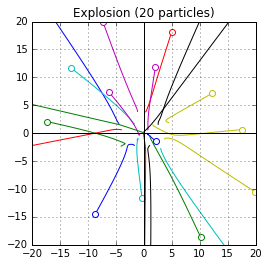

In [34]:
def coulomb(obj1, obj2, time):
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return np.array([(x1 - x2),(y1 - y2)]) / d ** 3

import random
random.seed(1234)

initial = []
for i in range(21):
    m = 1
    r = 5 * random.random()
    q = 2 * np.pi * random.random()
    r0 = r * np.array([np.cos(q), np.sin(q)])
    v = 2 * random.random()
    d = 2 * np.pi * random.random()
    v0 = v * np.array([np.cos(d), np.sin(d)])
    initial.append((m, r0, v0))

ps = PhysicalSystem(initial)
ps.interaction = coulomb
ps.increment(0.2, 45)
ps.plot2d()

plt.title('Explosion (20 particles)')

z = 20
plt.axis([-z,z,-z,z])
plt.show()

In [35]:
for i in range(45): # momentum is conserved
    print(sum(obj.momentum.values[i] for obj in ps.objs))

[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116  3.1456798 ]
[-1.81310116

**Explosion in a box (i.e., ideal gas)**

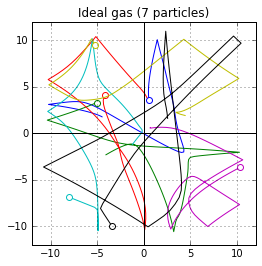

In [36]:
def coulomb(obj1, obj2, time):
    x1, y1 = obj1.position(time)
    x2, y2 = obj2.position(time)
    d = np.sqrt( (x1 - x2) ** 2 + (y1 - y2) ** 2 )
    return np.array([(x1 - x2),(y1 - y2)]) / d ** 3

def box(obj, time, dt): 
    box_size = 10
    dpx, dpy = 0, 0
    if time > min(obj.position.timeline): # must let the clock tick once
        x, y = obj.position(time)
        x_prev, y_prev = obj.position(time - dt)
        px, py = obj.momentum(time - dt/2)
        if abs(x) >= box_size and abs(x_prev) < box_size:
            dpx = -2 * px
        if abs(y) >= box_size and abs(y_prev) < box_size:
            dpy = -2 * py
    return np.array([dpx, dpy]) / dt

import random
random.seed(1234)

initial = []
for i in range(7):
    m = 1
    r = 5 * random.random()
    q = 2 * np.pi * random.random()
    r0 = r * np.array([np.cos(q), np.sin(q)])
    v = 2 * random.random()
    d = 2 * np.pi * random.random()
    v0 = v * np.array([np.cos(d), np.sin(d)])
    initial.append((m, r0, v0))

ps = PhysicalSystem(initial)
ps.interaction = coulomb
dt = 0.5
for obj in ps.objs:
    obj.forces.append(lambda time, obj=obj, dt=dt: box(obj, time, dt))
ps.increment(dt, 100)

ps.plot2d()
plt.title('Ideal gas (7 particles)')

z = 12
plt.axis([-z,z,-z,z])
plt.show()

# Chapter 9: Angular Dynamics

In [147]:
import cmath

class RigidObject(Particle):
    def __init__(self, mass=1, t0=0, r0=0, p0=0, v0=None, moi=1, q0=1+0j, L0=0+0j, w0=None):
        Particle.__init__(self, mass, t0, r0, p0, v0)
        self.moi = moi
        self.attitude = TimeSeries([(t0, q0)])
        self.angular_displacement = TimeSeries([(t0, cmath.phase(q0))])
        if self.moi and w0 is not None:
            self.angular_momentum = TimeSeries([(t0, self.moi * w0)])
        else:
            self.angular_momentum = TimeSeries([(t0, L0)])
        self.torques = []
    
    def add_torque(self, torque):
        self.torques.append(lambda t, obj=self: torque(obj, t))        
        
    def net_torque(self, time): # angular_momentum flow or rate of change
        net_torque = 0+0j
        for tau in self.torques:
            net_torque += tau(time)
        return net_torque

    def rotational_velocity(self, time): # attitude flow or rate of change
        if time > max(self.angular_momentum.timeline):
            time = max(self.angular_momentum.timeline)
        return self.angular_momentum(time) / self.moi
    
    def increment(self, dt, n=1):
        for i in range(n):
            Particle.increment(self, dt, 1)
            
            t = max(self.attitude.timeline)

            if len(self.attitude.timeline) == 1: # then only go forward half an increment            
                next_L = self.angular_momentum(t) + self.net_torque(t) * dt/2
                self.angular_momentum = TimeSeries() # throw out that "initial" value
            else: # reach back half an increment to calculate the new momentum value
                next_L = self.angular_momentum(t - dt/2) + self.net_torque(t) * dt                
                q = self.angular_displacement(t - dt)
                q += self.rotational_velocity(t + dt/2) * dt
                self.angular_displacement.append(t, q)

            self.angular_momentum.append(t + dt/2, next_L)
            next_attitude = self.attitude(t) * np.exp( 1j * self.rotational_velocity(t + dt/2) * dt )
            self.attitude.append(t + dt, next_attitude)

**Confirm calculation with constant angular acceleration**

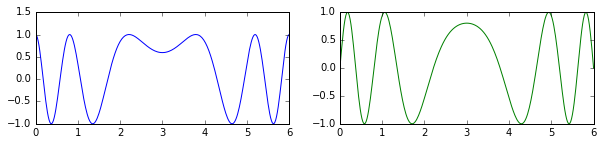

In [173]:
obj = RigidObject(w0=9)
obj.net_torque = lambda t: -3
obj.increment(0.02, 300)

t = obj.attitude.timeline
x = [z.real for z in obj.attitude.values]
y = [z.imag for z in obj.attitude.values]

plt.figure(figsize=[10,2])
plt.subplot(1, 2, 1)
plt.plot(t, x, 'b')
plt.subplot(1, 2, 2)
plt.plot(t, y, 'g')
plt.show()

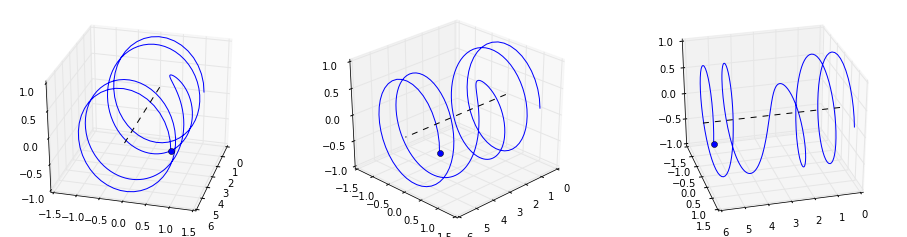

In [174]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.25))

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot(t, x, y)
ax.plot(t, [0]*len(t), [0]*len(t), 'k--')
ax.plot([t[-1]], [x[-1]], [y[-1]], 'b', marker='o')
ax.axis([0,6,-1.5,1.5])
ax.view_init(elev=30, azim=15)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.plot(t, x, y)
ax.plot(t, [0]*len(t), [0]*len(t), 'k--')
ax.plot([t[-1]], [x[-1]], [y[-1]], 'b', marker='o')
ax.axis([0,6,-1.5,1.5])
ax.view_init(elev=30, azim=45)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.plot(t, x, y)
ax.plot(t, [0]*len(t), [0]*len(t), 'k--')
ax.plot([t[-1]], [x[-1]], [y[-1]], 'b', marker='o')
ax.axis([0,6,-1.5,1.5])
ax.view_init(elev=30, azim=75)

plt.show()

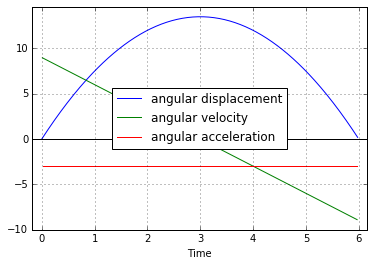

In [175]:
obj.angular_displacement.plot(toggle='012', 
                              labels=['angular displacement','angular velocity','angular acceleration'], 
                              legend_loc='center')